In [17]:
import numpy as np

import pandas as pd

In [18]:
url = "https://files.digital.nhs.uk/BA/9B79CF/T201812PDPI%20BNFT.csv"
df = pd.read_csv(url)

In [33]:
df2 = df.iloc[1:1000]

In [34]:
df2.head()

,SHA,PCT,PRACTICE,BNF CODE,BNF NAME,ITEMS,NIC,ACT COST,QUANTITY,PERIOD
1,Q44,01C,N81002,0101021B0AAAPAP,Sod Alginate/Pot Bicarb_Tab Chble 500mg,1,3.07,2.86,60.0,201812
2,Q44,01C,N81002,0101021B0BEACAH,Gaviscon_Liq Orig Aniseed Relief,1,12.99,12.07,900.0,201812
3,Q44,01C,N81002,0101021B0BEADAJ,Gaviscon Infant_Sach 2g (Dual Pack) S/F,3,81.94,76.09,255.0,201812
4,Q44,01C,N81002,0101021B0BEAIAL,Gaviscon Advance_Liq (Aniseed) (Reckitt),11,55.29,51.76,5400.0,201812
5,Q44,01C,N81002,0101021B0BEBEAL,Gaviscon Advance_Liq (Peppermint) S/F,3,10.24,9.64,1000.0,201812


Firstly we have to get a list of all the non generic drugs. The pattern for BNF codes Is referenced here https://ebmdatalab.net/prescribing-data-bnf-codes/
 In principle anything that has AA in the 10 and 11 position of the BNF code is a generic. And using the last two characters gives a pointer to the generic of any branded drugs.

In [37]:
import re
generic_lookup = {}

regex = re.compile(r"(\S{9})(\S\S)(\S\S)(\S\S)")

for index, row in df2.iterrows():
    code = row['BNF CODE']
    match = regex.match(code)
    if match:
        bnf = match.group(1)
        product = match.group(2)
        strength = match.group(3)
        generic_code = match.group(4)
        is_generic = False
        if product == 'AA':
            gen_code = code
            is_generic = True
        else:
            gen_code = "{}{}{}{}".format(bnf, 'AA', generic_code, generic_code)    
        if gen_code not in generic_lookup:
            generic_lookup[gen_code] = []
        if not is_generic:
            generic_lookup[gen_code].append(code)

In [41]:
len(generic_lookup.keys())

834

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B9B87836A0>]],
      dtype=object)

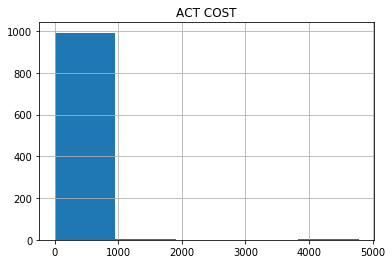

In [51]:
%matplotlib inline
df2.hist(column='ACT COST', bins=5)